In [2]:
import medmnist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
from acsconv.converters import ACSConverter, Conv2_5dConverter, Conv3dConverter

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [3]:
from medmnist import NoduleMNIST3D
dataset = NoduleMNIST3D(split='test',download=True)

Using downloaded and verified file: C:\Users\veedu\.medmnist\nodulemnist3d.npz


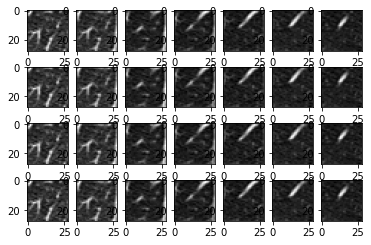

In [4]:
image=dataset[np.random.randint(len(dataset))][0] #
fig,ax = plt.subplots(4,7)
for i in range(4):
    for j in range(7):
        ax[i,j].imshow(image[0][j],cmap='gray')
plt.show()

In [5]:
data_flag = 'nodulemnist3d'
download = False

num_epochs = 3 #no. of times the NN is trained on the entire dataset
batch_size = 32 #no. of images before parameters are updated
lr = 0.001 

info = INFO[data_flag]
task = info['task'] #binary classification or multi-classification?
num_channels = info['n_channels'] #colour channels
num_classes = len(info['label']) #number of classes

DataClass = getattr(medmnist, info['python_class'])

In [105]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[.5], std=[.5])
])


train_data = DataClass(split='train', transform=transform,download=download)
for x,y in train_data:
    print(x,y)
train_loader = data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

ValueError: pic should be 2/3 dimensional. Got 4 dimensions.

In [102]:
class CNN_classification_model (nn.Module):
    def __init__(self):
        super(CNN_classification_model, self).__init__()
        self.model= nn.Sequential(
        
        #Conv layer 1    
        nn.Conv3d(1, 32, kernel_size=(3, 3, 3), padding=0),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),   
        
        #Conv layer 2  
        nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=0),
        nn.ReLU(),
        nn.MaxPool3d((2, 2, 2)),
               
        #Flatten
        nn.Flatten(),  
        #Linear 1
        nn.Linear(2**3*64, 128), 
        #Relu
        nn.ReLU(),
        #BatchNorm1d
        nn.BatchNorm1d(128),
        #Dropout
        nn.Dropout(p=0.15),
        #Linear 2
        nn.Linear(128, num_classes)
        )
    

    def forward(self, x):
        # Set 1
        out = self.model(x)
        return out

# Instantiate the model
model = Net()

# define loss function and optimizer
criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [104]:
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/37 [00:00<?, ?it/s]


ValueError: pic should be 2/3 dimensional. Got 4 dimensions.